# Geely Auto - A Chinese Automobile Company

The company aspires to enter the US market by setting up their manufacturing unit in USA and produce cars locally to give compete in the US market against its counterparts. 

## Business Goal
To model the price of cars with the available information about different cars in the US market. It will then help the management to understand the variation in prices due to different features which can accordingly manipulate the design of the cars, the business strategy etc. to meet certain price levels.

## Objectives for analysis
- Find suitable variables that tend to influence the prices of a car in the US market.
- Estimate how much of the variation in prices can be explained by those variables or factors.

## Analysis Workflow 
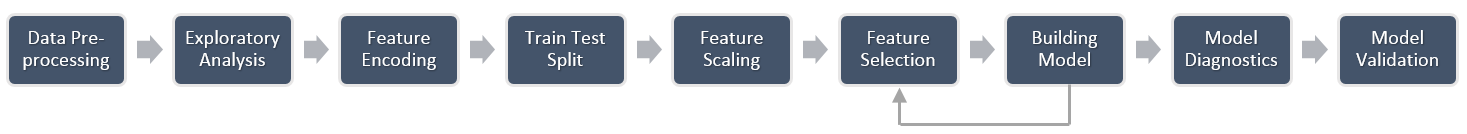

## Reading data

In [ ]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as pe
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.graphics.regressionplots import influence_plot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
#Reading the CSV file

data = pd.read_csv('../input/car-price-prediction/CarPrice_Assignment.csv')


In [ ]:
#Creating a DataFrame for the CarPrice data
carprice_df = pd.DataFrame(data)
carprice_df.head()

In [ ]:
#Undetanding the shape and data types of the data
carprice_df.info()

There are a total of 205 observations with no missing values.

## Data Preprocessing
- Exploring Data
- Cleaning Data
- Deriving New Metrics

### Categorical Variables

In [ ]:
# Number of Unique Values in each categorical column
carprice_df.select_dtypes(exclude = np.number).nunique()

In [ ]:
#Splitting the carName column into Company and Model name
car_name_df = carprice_df.CarName.str.split(n = 1, expand = True)
carprice_df.insert(loc = 2,column = "car_name", value = car_name_df[1])
carprice_df.insert(loc = 2,column = "car_company", value = car_name_df[0])
carprice_df.drop(columns = "CarName", inplace = True)
carprice_df.head()

In [ ]:
# Number of Unique Values in each categorical column
carprice_df.select_dtypes(exclude = np.number).nunique()

In [ ]:
#Dropping the car_name or model name column due to high cardinality

carprice_df.drop(columns = ["car_name"], inplace = True)
print("car_name column dropped from the dataframe")

In [ ]:
#Unique values of each categorical column
columns = list(carprice_df.select_dtypes(exclude =  np.number).columns)
for i in columns:
    print(f"{i.upper()}: {' , '.join(carprice_df[i].unique())} \n")

In [ ]:
#Removing error from names of car companies
print(f"Unique values before cleaning: {carprice_df.car_company.nunique()}")
carprice_df.car_company.replace(to_replace = ["alfa-romero","Nissan","porcshce", "toyouta","maxda", "vokswagen", "vw"], 
                                value = ["alfa-romeo","nissan", "porsche","toyota","mazda", "volkswagen","volkswagen"], 
                                inplace = True)
print(f"Unique values after cleaning : {carprice_df.car_company.nunique()}")

Categorical variables have been cleaned with no errors remaining. We will further treat the categorical variables during feature encoding.

### Numerical Variables

In [ ]:
#Checking the numeric columns or features
carprice_df.describe(percentiles= [0.25, 0.50, 0.75, 0.95])

All the numeric values seem to be okay for the analysis i.e. there are no extreme values apart from the price column. We will further study the price column separtely.

In [ ]:
# Number of unique values in each numeric column

carprice_df.select_dtypes(include = np.number).nunique()

In [ ]:
#Setting the index of the dataframe as car_id as it has all unique values.

carprice_df = carprice_df.set_index("car_ID")
carprice_df.head()

In [ ]:
#Understanding the Symboling feature
carprice_df.symboling.unique()

`Symboling` corresponds to the degree by which the automoblie is more `risky` than its price indicates. The higher the rating the riskier. Although this feature is of numeric datatype we can use it as a `categorical one of ordinal scale`. We will not be required to encode the feature as it is already in encoded format. 

### Outlier Analysis
- Remove observations with extreme values

In [ ]:
#Using Z-Score to detect outliers
from scipy.stats import zscore
index = carprice_df[abs(zscore(carprice_df["price"]))>=3].index
index

In [ ]:
#Removing Outliers
carprice_df.drop(index, inplace = True)
print("Outliers Removed Successfully")

## Exploratory Data Anlaysis
Understanding the variation in price of car due to various factors and learning the correlation between numerous numeric features.

In [ ]:
#Plot 1
fig = make_subplots(rows =2, cols = 2, subplot_titles = ["Distribution of Price W.R.T Car compnay",
                                                        "Distribution of Car Company",
                                                        "Distribution of Price W.R.T Fuel System",
                                                        "Distribution of Fuel System"])
fig.add_trace(go.Box(x = carprice_df["car_company"], y = carprice_df["price"], name = "Car Company"),
              row = 1, col =1)
fig.add_trace(go.Histogram(x = carprice_df["car_company"], histnorm = "percent", name = "Car Company"),
              row = 1, col =2)
fig.add_trace(go.Box(x = carprice_df["fuelsystem"], y = carprice_df["price"], name = "Fuel System"),
              row = 2, col =1)
fig.add_trace(go.Histogram(x = carprice_df["fuelsystem"], histnorm = "percent", name = "Fuel System"),
              row = 2, col =2)
fig.update_layout(height = 700,
                 xaxis1 = dict(title = "Car company"),
                 xaxis2 = dict(title = "Car compnay"),
                 xaxis3 = dict(title = "Fuel System"),
                 xaxis4 = dict(title = "Fuel System"),
                 yaxis1 = dict(title = "Price"),
                 yaxis2 = dict(title = "Percentage"),
                 yaxis3 = dict(title = "Price"),
                 yaxis4 = dict(title = "Percentage"))
fig.show()

- Different companies have cars in different price segments.
- Companies such as Mercury and Renault have very few models in the data set.
- There is considerable difference in the median prices of cars for different fuel systems.
- More than 75% of models are fitted with MPFI and 2BBL fuel systems.


In [ ]:
#Plot 2
fig = make_subplots(rows =2, cols = 2, subplot_titles = ["Distribution of Price W.R.T Fuel Type",
                                                        "Distribution of Fuel Type",
                                                        "Distribution of Price W.R.T Car Body",
                                                        "Distribution of Car Body"])
fig.add_trace(go.Box(x = carprice_df["fueltype"], y = carprice_df["price"], name = "Fuel Type" ),
              row = 1, col =1)
fig.add_trace(go.Histogram(x = carprice_df["fueltype"], histnorm = "percent", name = "Fuel Type"),
              row = 1, col =2)
fig.add_trace(go.Box(x = carprice_df["carbody"], y = carprice_df["price"], name = "Car Body"),
              row = 2, col =1)
fig.add_trace(go.Histogram(x = carprice_df["carbody"], histnorm = "percent", name = "Car Body"),
              row = 2, col =2)
fig.update_layout(height = 700,
                 xaxis1 = dict(title = "Fuel Type"),
                 xaxis2 = dict(title = "Fuel Type"),
                 xaxis3 = dict(title = "Car Body"),
                 xaxis4 = dict(title = "Car Body"),
                 yaxis1 = dict(title = "Price"),
                 yaxis2 = dict(title = "Percentage"),
                 yaxis3 = dict(title = "Price"),
                 yaxis4 = dict(title = "Percentage"))
fig.show()

- Diesel cars are more expensive then gas cars in general.
- 90% of the car models run on gas.
- Convertibles are the most expensive ones.
- More than 80% of the models fall in sedan or hatchback category.

In [ ]:
#Plot 3
fig = make_subplots(rows =2, cols = 2, subplot_titles = ["Distribution of Price W.R.T Drive Wheel",
                                                        "Distribution of Driv Wheel",
                                                        "Distribution of Price W.R.T Cylinder Count",
                                                        "Distribution of Cylinder Count"])
fig.add_trace(go.Box(x = carprice_df["drivewheel"], y = carprice_df["price"], name = "Drive Wheel" ),
              row = 1, col =1)
fig.add_trace(go.Histogram(x = carprice_df["drivewheel"], histnorm = "percent", name = "Drive Wheel"),
              row = 1, col =2)
fig.add_trace(go.Box(x = carprice_df["cylindernumber"], y = carprice_df["price"], name = "Cylinder Count"),
              row = 2, col =1)
fig.add_trace(go.Histogram(x = carprice_df["cylindernumber"], histnorm = "percent", name = "Cylinder Count"),
              row = 2, col =2)
fig.update_layout(height = 700,
                 xaxis1 = dict(title = "Drive Wheel"),
                 xaxis2 = dict(title = "Drive Wheel"),
                 xaxis3 = dict(title = "Cylinder Count"),
                 xaxis4 = dict(title = "Cylinder Count"),
                 yaxis1 = dict(title = "Price"),
                 yaxis2 = dict(title = "Percentage"),
                 yaxis3 = dict(title = "Price"),
                 yaxis4 = dict(title = "Percentage"))
fig.show()

- Rear Wheel drive cars are priced higher than front wheel and all wheel drive cars.
- Increase in the number of cylinders in the engine is associated with the increase in price of a car.

In [ ]:
#Boxplot to study variation in price of cars with respect to other features
fig = make_subplots(rows =2, cols = 2, subplot_titles = ["Distribution of Price W.R.T Engine Location",
                                                        "Distribution of Engine Location",
                                                        "Distribution of Price W.R.T Engine Type",
                                                        "Distribution of Engine Type"])
fig.add_trace(go.Box(x = carprice_df["enginelocation"], y = carprice_df["price"], name = "Engine Location" ),
              row = 1, col =1)
fig.add_trace(go.Histogram(x = carprice_df["enginelocation"], histnorm = "percent", name = "Engine Location"),
              row = 1, col =2)
fig.add_trace(go.Box(x = carprice_df["enginetype"], y = carprice_df["price"], name = "Engine Type"),
              row = 2, col =1)
fig.add_trace(go.Histogram(x = carprice_df["enginetype"], histnorm = "percent", name = "Engine Type"),
              row = 2, col =2)
fig.update_layout(height = 700,
                 xaxis1 = dict(title = "Engine Location"),
                 xaxis2 = dict(title = "Engine Location"),
                 xaxis3 = dict(title = "Engine Type"),
                 xaxis4 = dict(title = "Engine Type"),
                 yaxis1 = dict(title = "Price"),
                 yaxis2 = dict(title = "Percentage"),
                 yaxis3 = dict(title = "Price"),
                 yaxis4 = dict(title = "Percentage"))
fig.show()

- Cars with engine located at the rear are priced almost 3x more than the ones with engine in front.

In [ ]:
#Correlation between various numeric features depicted using a heatmap
plt.figure(figsize = (10,8))
fig = sns.heatmap(carprice_df.corr(), annot = True)
plt.show()

There is high correlation amongst variables such as car length, car width, car height, curbweight, etc.


## Feature Encoding
Converting categorical variables into numeric types using techniques like Dummy encoding, label encoding and others.
This will allow us to use categorical variables in the Regression model.

In [ ]:
#Label encoding the column number of cylinders

carprice_df["cylindernumber"] = carprice_df.cylindernumber.map({"two": 0, "three": 1, "four": 2, "five" : 3, "six" : 4, "eight": 5, "twelve": 6})
print(f"Cylinder Number column encoded as {carprice_df['cylindernumber'].unique()}")

In [ ]:
#function to encode variables with high cardinality

def encoder(column_name):    
    #Storing the median price values for each category in a datframe 
    median_price = carprice_df.groupby(column_name)["price"].median().to_frame().reset_index()
    median_price.sort_values(by = "price", inplace = True) #Sorting the frame
    median_price["price"]  = median_price["price"].map({i: index for index, i in enumerate(median_price["price"])}) #Mapping with non-negative integers
    median_price = median_price.set_index(column_name) #Again set the index to category names
    median_price = median_price.to_dict() #Convert the frame back to dictionary
    median_price  = median_price["price"] #Storing the dictionary with price values as the mapped dictionary is the value of price key
    return median_price #Returning the map or dict

 In the above method we use the median price of cars for each category to retrive a sorted order of the categories which then are label encoded and mapped with the categories to include in the model. This helps us limit the number of dimensions and is reliable. Using Dummy variables increases the dimensions which makes our model unreliable as we have a very limited set of observations.

In [ ]:
#Encoding Engine type variable
enginetype_dict = encoder("enginetype") #Storing enginetype_map in enginetype_dict for reference
carprice_df["enginetype"] = carprice_df.enginetype.map(enginetype_dict) #mapping the labels
#Encoding Fuel System Variable
fuelsystem_dict = encoder("fuelsystem") #Storing dict for fuelsystem in fuelsystem_dict for reference
carprice_df["fuelsystem"] = carprice_df.fuelsystem.map(fuelsystem_dict) #mapping the labels
#Encoding Carbody varibale
carbody_dict = encoder("carbody") #Storing dict for carbody in carbody_dict for reference
carprice_df["carbody"] = carprice_df.carbody.map(carbody_dict) #Mapping the labels

In [ ]:
print(f"{enginetype_dict}\n")
print(f"{fuelsystem_dict}\n")
print(carbody_dict)

In [ ]:
#Encoding Car_company variable using similar technique as used above.

#Storing the median prices of cars for respective companies in a dataframe
median_price = carprice_df.groupby("car_company")["price"].median().to_frame().reset_index()
#Using the cut function to create three price segements low, mid and high range
median_price["price"] = pd.cut(median_price["price"],bins = [0,10000,20000,50000], labels = ["low range", "mid range", "high range"])
print(f"Use this encoding for reference: {median_price}")
median_price = median_price.set_index("car_company") #Resetting the index to car_company
median_price  = median_price.to_dict() #Storing the data frame a dictionary
median_price = median_price["price"] #Storing the dictionary with price values as the mapped dictionary is the value of price key
carprice_df["car_company"] = carprice_df.car_company.map(median_price) #Mapping th values to car_company column


In the above encoding we divide car manufacturers into Low, Mid and High Price car maker segments to tackle high cardinality.

In [ ]:
#Finally creating dummy variable for all the categorical variables and dropping the first column of all to avoid multicolinearity
print(f"Number of columns before Dummy encoding - {carprice_df.shape[1]}")
carprice_df = pd.get_dummies(carprice_df, drop_first = True)
print(f"Number of columns after Dummy encoding - {carprice_df.shape[1]}")

In [ ]:
carprice_df.head()

## Feature Scaling, Selection and Model Building

### Feature Scaling
We are scaling features to make better inferences of the infulence of independent variables on the dependent variable. This will bring down the training data in the range of `0-1`.
Using `MinMaxScaler` method of Sklearn.

### Feature Selection
We are taking a hybrid approach using `Recursive Feature Selection` technique to filter top 10-15 influencers and then using `Backward Elimination` to drop each insignificant variable to find the top influencers.

### Model Building
We are using `Gauss Markov Theorem` to find the best fit model and `Variance Inflation Factor` to check for `multicolinearity`.

<b>Repeating the process of model building to remove irrelevant features until significant features are found and multicolinearity is removed.

In [ ]:
#Splitting the dataset in train and test dataset in a ratio of 70-30
train_df, test_df = train_test_split(carprice_df, train_size = 0.7, random_state = 42)

In [ ]:
#Scaling the training dataset
scaler = MinMaxScaler() #Creating a MinMaxScaler object
train_df.loc[:,:] = scaler.fit_transform(train_df.loc[:,:]) #Fitting and transforming the dataset

In [ ]:
#Creating x_train and y_train
y_train = train_df.pop("price") #Storing the response variable price in y_train
x_train = train_df

In [ ]:
#Creating a LinearRegression model using sklearn as we can find the features using RFE only after fitting a model
lm = LinearRegression() #Creating Linear Regression Object
lm_model = lm.fit(x_train, y_train) #Fitting the model

In [ ]:
#Using Recursive Feature Elimination to pick top 10-15 features and ranking them
rfe = RFE(lm_model, 15).fit(x_train,y_train) #Creating a RFE object and then fitting it on training data
list(zip(train_df.columns, rfe.support_, rfe.ranking_)) #Name of feature along with the ranking give to it by the RFE object

In [ ]:
#Storing the selected features in a variable
cols = list(train_df.columns[rfe.support_])
x_train = sm.add_constant(train_df[cols]) #Adding a constant for the intercept term in the x_train

#### Model 1

In [ ]:
ols_model = sm.OLS(y_train, x_train).fit() #Creating and fitting the OLS model on the training set

ols_model.summary2() #Viewing the summary statistics

Variance Inflation Factor is used to check if there is multicolinearity amongst independent variables.

In [ ]:
#Check for multicolinearity
vif = pd.DataFrame() #Creating a new dataframe
vif["Features"] = cols #Storing the column names as a column in vif dataframe
vif["VIF"] = [variance_inflation_factor(x_train[cols].values, i) for i in range(x_train.shape[1]-1)] #Computing VIF for each variable
vif

#### Model 2
Removing `carlength` featuren due to high VIF

In [ ]:
cols.remove("carlength")
x_train = sm.add_constant(train_df[cols])
#Model fitting
ols_model = sm.OLS(y_train, x_train).fit()
ols_model.summary2()

In [ ]:
vif = pd.DataFrame()
vif["Features"] = cols
vif["VIF"] = [variance_inflation_factor(x_train[cols].values, i) for i in range(x_train.shape[1]-1)]
vif

#### Model 3
Removing `cylindernumber` feature due to high VIF

In [ ]:
cols.remove("cylindernumber")
x_train = sm.add_constant(train_df[cols])

ols_model = sm.OLS(y_train, x_train).fit()
ols_model.summary2()

In [ ]:
vif = pd.DataFrame()
vif["Features"] = cols
vif["VIF"] = [variance_inflation_factor(x_train[cols].values, i) for i in range(x_train.shape[1]-1)]
vif

#### Model 4
Removing `highwaympg` feature due to high VIF

In [ ]:
cols.remove("highwaympg")
x_train = sm.add_constant(train_df[cols])

ols_model = sm.OLS(y_train, x_train).fit()
ols_model.summary2()

In [ ]:
vif = pd.DataFrame()
vif["Features"] = cols
vif["VIF"] = [variance_inflation_factor(x_train[cols].values, i) for i in range(x_train.shape[1]-1)]
vif

#### Model 5
Removing `boreratio` feature due to high VIF

In [ ]:
cols.remove("boreratio")
x_train = sm.add_constant(train_df[cols])

ols_model = sm.OLS(y_train, x_train).fit()
ols_model.summary2()

In [ ]:
vif = pd.DataFrame()
vif["Features"] = cols
vif["VIF"] = [variance_inflation_factor(x_train[cols].values, i) for i in range(x_train.shape[1]-1)]
vif

#### Model 6
It is worth mentioning here that although curbweigth has highest multicolinearity as of now we still do not remove it as it explains high variation in the prices of cars which can be inferred from its coefficient in the model.
Hence we remove `horsepower`.

In [ ]:
cols.remove("horsepower")
x_train = sm.add_constant(train_df[cols])

ols_model = sm.OLS(y_train, x_train).fit()
ols_model.summary2()

In [ ]:
vif = pd.DataFrame()
vif["Features"] = cols
vif["VIF"] = [variance_inflation_factor(x_train[cols].values, i) for i in range(x_train.shape[1]-1)]
vif

#### Model 7
Remove the `carheight` feature

In [ ]:
cols.remove("carheight")
x_train = sm.add_constant(train_df[cols])

ols_model = sm.OLS(y_train, x_train).fit()
ols_model.summary2()

In [ ]:
vif = pd.DataFrame()
vif["Features"] = cols
vif["VIF"] = [variance_inflation_factor(x_train[cols].values, i) for i in range(x_train.shape[1]-1)]
vif

#### Model 8
Removing the `carwidth` feature

In [ ]:
cols.remove("carwidth")
x_train = sm.add_constant(train_df[cols])

ols_model = sm.OLS(y_train, x_train).fit()
ols_model.summary2()

In [ ]:
vif = pd.DataFrame()
vif["Features"] = cols
vif["VIF"] = [variance_inflation_factor(x_train[cols].values, i) for i in range(x_train.shape[1]-1)]
vif

#### Model 9
Removing the `fueltype_gas` feature due to high VIF

In [ ]:
cols.remove("fueltype_gas")
x_train = sm.add_constant(train_df[cols])

ols_model = sm.OLS(y_train, x_train).fit()
ols_model.summary2()

In [ ]:
vif = pd.DataFrame()
vif["Features"] = cols
vif["VIF"] = [variance_inflation_factor(x_train[cols].values, i) for i in range(x_train.shape[1]-1)]
vif

#### Model 10
Removing the `carbody` feature due to high p-value which renders the variable statistically insignificant.

In [ ]:
cols.remove("carbody")
x_train = sm.add_constant(train_df[cols])

ols_model = sm.OLS(y_train, x_train).fit()
ols_model.summary2()

In [ ]:
vif = pd.DataFrame()
vif["Features"] = cols
vif["VIF"] = [variance_inflation_factor(x_train[cols].values, i) for i in range(x_train.shape[1]-1)]
vif

#### Final Model
Lastly we remove the `aspiration_turbo` feature due to high p-value.

In [ ]:
cols.remove("aspiration_turbo")
x_train = sm.add_constant(train_df[cols])

ols_model = sm.OLS(y_train, x_train).fit()
ols_model.summary2()

In [ ]:
vif = pd.DataFrame()
vif["Features"] = cols
vif["VIF"] = [variance_inflation_factor(x_train[cols].values, i) for i in range(x_train.shape[1]-1)]
vif

Finally we have selected top 5 features with low multicolinearity and high significance.
Features are curbweight, compressionratio, car_company_low range, car_company_mid range and enginelocation_rear. Although Compression Rate has very less association with pricing of a car. Hence we can consider only remaining four for our objective.

### Residual Analysis
We will verify the assumptions for residuals made before model builing

In [ ]:
#Check for Normality- Whether the residual follow a normal distribution or not
sns.distplot(ols_model.resid)
plt.title("P-P Plot")
plt.show()

The plot suggests that the residuals are approximately normally distributed.

In [ ]:
#Test for Homoscedasticity - Whether the variance of errors is constant or not.
plt.scatter(x = ols_model.fittedvalues, y = ols_model.resid) #Scatter Plot between Fitted Values and Residuals
plt.title("Fitted Price values VS Errors")
plt.xlabel("Normalized Fitted Values")
plt.ylabel("Normalized Residuals")
plt.show()

### Model Validation
Predicting the Y values for test data set and computing R2_score and Mean Squared Error to check performance

In [ ]:
#Tranforming the test dataframe using the scaler object. We do not fit the frame again as we already fitted it on the train set
test_df.loc[:,:] = scaler.transform(test_df)

In [ ]:
#Creating y_test and x_test
y_test = test_df.pop("price")
x_test = test_df[cols]
x_test = sm.add_constant(x_test)

In [ ]:
#Storing predicted values for y in y_pred
y_pred = ols_model.predict(x_test)

In [ ]:
#Checking model performance using r2_score method
print(f"The Coefficient of determination for test set is {round(r2_score(y_test, y_pred),3)}")

In [ ]:
#Checking the mean squared error
print(f"The mean squared error for the test set is {round(mean_squared_error(y_test,y_pred),3)}")

The R-sqaured value of train set and test set is very close and the value of Mean Squared Error is approximately 0. Hence from the value of R-squared and mean Squared Error it is evident that the model is performing very well. 

### Conclusion
Curbweight of a car, location of the engine and the range operated in by the company of a car have a strong influence on the pricing of a car. If an engine is located at the rear end of the car it positively influences the price as cars with rear engines are Rear Wheel Drives and are mainly find in high end racing cars for better steering and other benefits. Also if a car is manufactured by car companies like Honda or Toyota, its price would be generally less than the of a car manufactured by companies like BMW and Porche. Hence a negative association between car price and low - mid range car companies.